# zaltys Tutorial

In [1]:
# Here we demonstrate the capabilities of the zaltys_so and zaltys_time
# modules. We first generate the Hamiltonian and other operators, relevant for
# investigating the spin Hall mode in a trapped Rashba spin-orbit coupled
# system. After diagonalizing the system, we compute the time evolution of the
# center-of-mass position <X> and the spin dipole moment <Y SZ> in response
# to displacement of the center-of-mass of the system in the X direction.

In [2]:
import numpy as np

# User input
eec = 10 # energy cutoff, which determines the number of basis states
         # and steeply increases evaluation time
v = 0.1  # Rashba spin-orbit coupling strength
x0 = 0.1 # initial center-of-mass displacement amplitude

# We will investigate the response for several single-occupied
# states, corresponding to T=0 fermions
start_state = 0 # the lowest-energy occupied eigenstate is start_state
stop_state  = 2 # the highest-energy occupied eigenstate is stop_state-1

# Number of processes to run concurrently when generating the plot
no_of_processes = 2

# Options for the plot
no_of_steps = 250      # Number of points, linearly increases evaluation time
t_min = 0.             # Time point at which to start the plot with 
                       # respect to the moment of translation
t_max = 10.01 * (2*np.pi) # Time point at which to end the plot

# Generate operators

In [3]:
# Preliminary steps: generating the Hamiltonian and other operators
from zaltys_so import (
    generate_states,
    generate_rashba_hamiltonian,
    generate_translation_operator,
    generate_x_operator,
    generate_ysz_operator
)

state_list = generate_states(eec)
rashba_hamiltonian = generate_rashba_hamiltonian(v, eec, state_list)
translation_operator = generate_translation_operator(x0, eec, state_list)
x_operator = generate_x_operator(state_list)
ysz_operator = generate_ysz_operator(state_list)

# Diagonalize the Hamiltonian

In [4]:
%%time

from numpy import linalg as LA

# Get eigenvectors and eigenvalues - most memory and CPU intensive step
spectrum, eigenvectors = LA.eigh(rashba_hamiltonian.todense())
print('Total number of states: {}.'.format(len(spectrum)))

# Converting here such that eigenvectors are only kept as numpy arrays
eigenvectors = np.array(eigenvectors.T)

Total number of states: 110.
CPU times: user 14.1 ms, sys: 53 µs, total: 14.1 ms
Wall time: 13.3 ms


# Consistency check

In [5]:
# Does translating lead to <x> / x0 = 1 for the highest-energy state 
# considered? Expand the basis if this significantly deviates from 1.
# This is especially relevant for large v or high-energy states.

import scipy.sparse as sps

ev_state = sps.csr_matrix.dot(translation_operator, eigenvectors[stop_state - 1])
x_avg = np.dot( ev_state.conj() , sps.csr_matrix.dot(x_operator, ev_state) )
print('{:.6f}'.format((x_avg / x0).real))

1.000000


# Plot

In [6]:
%%time

from zaltys_time import zero_kelvin_fermions

dt = t_max / (no_of_steps - 1.)
t_list = [t_min + dt*t_step for t_step in range(0, no_of_steps)]

[average_x, average_ysz] = zero_kelvin_fermions(translation_operator, x_operator, ysz_operator, 
                             eigenvectors, spectrum,
                             x0, no_of_processes,
                             start_state, stop_state,
                             t_list)

CPU times: user 199 ms, sys: 80.8 ms, total: 280 ms
Wall time: 435 ms


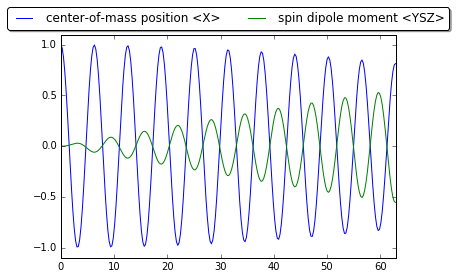

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(t_list, average_x, label='center-of-mass position <X>')
ax.plot(t_list, average_ysz, label='spin dipole moment <YSZ>')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=3, fancybox=True, shadow=True)
plt.axis([t_min, t_max, -1.1, 1.1])
plt.show()